In [1]:
# ===============================
# 0. Imports & configuration
# ===============================
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.applications import mobilenet_v2
from tensorflow.keras.preprocessing import image

from PIL import Image

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)

plt.rcParams["figure.figsize"] = (8, 5)


print("GPUs visibles :", tf.config.list_physical_devices('GPU'))



2025-12-27 10:25:24.306769: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-27 10:25:24.420154: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1766827524.467976   14769 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766827524.481121   14769 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-12-27 10:25:24.587653: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

GPUs visibles : [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


W0000 00:00:1766827526.429965   14769 gpu_device.cc:2433] TensorFlow was not built with CUDA kernel binaries compatible with compute capability 12.0. CUDA kernels will be jit-compiled from PTX, which could take 30 minutes or longer.


In [2]:
import tensorflow as tf
print("TF:", tf.__version__)
print("GPU:", tf.config.list_physical_devices('GPU'))


TF: 2.18.0
GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
# ===============================
# 1. Chargement des données Flipkart
# ===============================

# À ADAPTER : chemin vers ton fichier CSV
DATA_PATH = "../data/Flipkart/flipkart_com-ecommerce_sample_1050.csv"

df = pd.read_csv(DATA_PATH)

print("Shape du dataset brut :", df.shape)
df.head()


Shape du dataset brut : (1050, 15)


,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa..."
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",..."
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,Key Features of SANTOSH ROYAL FASHION Cotton P...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,Key Features of Jaipur Print Cotton Floral Kin...,No rating available,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa..."


In [5]:
df.columns


Index(['uniq_id', 'crawl_timestamp', 'product_url', 'product_name',
       'product_category_tree', 'pid', 'retail_price', 'discounted_price',
       'image', 'is_FK_Advantage_product', 'description', 'product_rating',
       'overall_rating', 'brand', 'product_specifications'],
      dtype='object')

In [6]:
# ===============================
# 2. Préparation des colonnes utiles
# ===============================

def extract_main_category(tree_str):
    """
    Extrait la catégorie principale depuis product_category_tree.
    Exemple :
    "[""Home Furnishing >> Curtains & Accessories >> ..."" ]"
    -> "Home Furnishing"
    """
    if pd.isna(tree_str):
        return np.nan
    s = str(tree_str).strip()
    # On enlève les crochets et guillemets
    s = s.strip("[]")
    s = s.replace('"', '')
    # On prend le premier segment avant '>>'
    first_segment = s.split(">>")[0]
    return first_segment.strip()

df["main_category"] = df["product_category_tree"].apply(extract_main_category)

df[["product_name", "main_category"]].head()


,product_name,main_category
0,Elegance Polyester Multicolor Abstract Eyelet ...,Home Furnishing
1,Sathiyas Cotton Bath Towel,Baby Care
2,Eurospa Cotton Terry Face Towel Set,Baby Care
3,SANTOSH ROYAL FASHION Cotton Printed King size...,Home Furnishing
4,Jaipur Print Cotton Floral King sized Double B...,Home Furnishing


In [7]:
def build_text(row):
    name = str(row.get("product_name", ""))
    desc = str(row.get("description", ""))
    return (name + " " + desc).strip()

df["text"] = df.apply(build_text, axis=1)


In [33]:
IMAGE_DIR = "../data/Flipkart/Images/"

def build_image_path(img_filename):
    if pd.isna(img_filename):
        return np.nan
    return os.path.join(IMAGE_DIR, str(img_filename))

df["image_path"] = df["image"].apply(build_image_path)


In [34]:
# On enlève les lignes sans texte, label ou image
df_clean = df.dropna(subset=["text", "main_category", "image_path"]).reset_index(drop=True)
print("Shape après nettoyage :", df_clean.shape)

df_clean[["text", "main_category", "image_path"]].head()


Shape après nettoyage : (1050, 18)


,text,main_category,image_path
0,Elegance Polyester Multicolor Abstract Eyelet ...,Home Furnishing,../data/Flipkart/Images/55b85ea15a1536d46b7190...
1,Sathiyas Cotton Bath Towel Specifications of S...,Baby Care,../data/Flipkart/Images/7b72c92c2f6c40268628ec...
2,Eurospa Cotton Terry Face Towel Set Key Featur...,Baby Care,../data/Flipkart/Images/64d5d4a258243731dc7bbb...
3,SANTOSH ROYAL FASHION Cotton Printed King size...,Home Furnishing,../data/Flipkart/Images/d4684dcdc759dd9cdf4150...
4,Jaipur Print Cotton Floral King sized Double B...,Home Furnishing,../data/Flipkart/Images/6325b6870c54cd47be6ebf...


In [35]:
# ===============================
# 2.5 Échantillonnage 
# ===============================

N_SAMPLES = 3000  # À ajuster selon ta machine

if len(df_clean) > N_SAMPLES:
    df_sample = df_clean.sample(N_SAMPLES, random_state=RANDOM_STATE).reset_index(drop=True)
else:
    df_sample = df_clean.copy()

print("Shape de l'échantillon utilisé :", df_sample.shape)


Shape de l'échantillon utilisé : (1050, 18)


In [36]:
# ===============================
# 3. Aperçu rapide
# ===============================
N_EXEMPLES = 3

sample_df = df_sample.sample(N_EXEMPLES, random_state=RANDOM_STATE)

for idx, row in sample_df.iterrows():
    print("="*60)
    print("Catégorie principale :", row["main_category"])
    print("Nom produit :", row["product_name"])
    print("Texte :", row["text"][:300], "...")
    print("Image path :", row["image_path"])


Catégorie principale : Computers
Nom produit : Zyxel PLA-4205
Texte : Zyxel PLA-4205 Buy Zyxel PLA-4205 only for Rs. 8100 from Flipkart.com. Only Genuine Products. 30 Day Replacement Guarantee. Free Shipping. Cash On Delivery! ...
Image path : ../data/Flipkart/Images/833a87b0af3b84fe246d2ebf271af177.jpg
Catégorie principale : Kitchen & Dining
Nom produit : Philips 9.5 W LED B22 3000K A55 IND Bulb
Texte : Philips 9.5 W LED B22 3000K A55 IND Bulb Buy Philips 9.5 W LED B22 3000K A55 IND Bulb for Rs.419 online. Philips 9.5 W LED B22 3000K A55 IND Bulb at best prices with FREE shipping & cash on delivery. Only Genuine Products. 30 Day Replacement Guarantee. ...
Image path : ../data/Flipkart/Images/55195de3873fffaa9e37b041533d7305.jpg
Catégorie principale : Computers
Nom produit : Lapguard Lenovo IdeaPad V470 6 Cell Laptop Battery
Texte : Lapguard Lenovo IdeaPad V470 6 Cell Laptop Battery Lapguard Lenovo IdeaPad V470 6 Cell Laptop Battery
                         Price: Rs. 1,799
				
			The

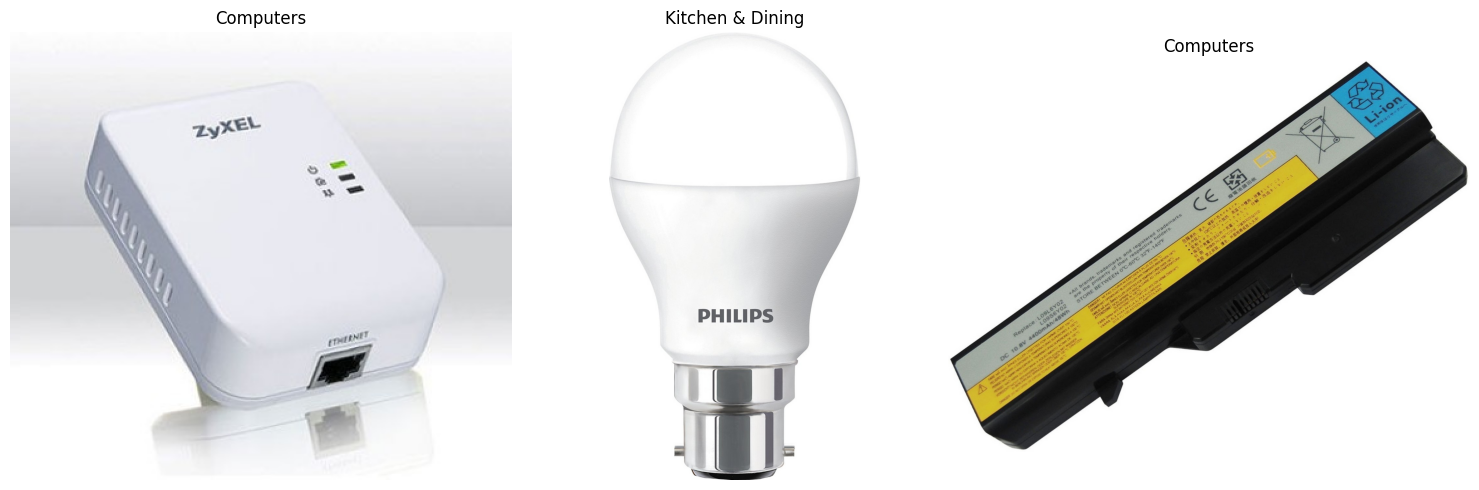

In [37]:
# Affichage des images
fig, axes = plt.subplots(1, N_EXEMPLES, figsize=(15, 5))

for ax, (_, row) in zip(axes, sample_df.iterrows()):
    img_path = "../data/"+row["image_path"]
    try:
        img = Image.open(img_path).convert("RGB")
        ax.imshow(img)
        ax.set_title(str(row["main_category"]))
        ax.axis("off")
    except Exception as e:
        ax.set_title("Erreur\n" + os.path.basename(str(img_path)))
        ax.axis("off")
        print(f"Impossible de charger {img_path} :", e)

plt.tight_layout()
plt.show()


In [38]:
# ===============================
# 4. Train / Test split
# ===============================

X_text = df_sample["text"].values
X_img_paths = df_sample["image_path"].values
y = df_sample["main_category"].values

X_text_train, X_text_test, X_img_train, X_img_test, y_train, y_test = train_test_split(
    X_text, X_img_paths, y,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y
)

len(X_text_train), len(X_text_test)


(840, 210)

In [39]:
# ===============================
# 5. Features texte : TF-IDF
# ===============================
tfidf_vectorizer = TfidfVectorizer(
    max_features=10000,
    ngram_range=(1, 2),
    stop_words=None  # dataset en anglais mais très mix, on peut laisser None
)

X_text_train_tfidf = tfidf_vectorizer.fit_transform(X_text_train)
X_text_test_tfidf = tfidf_vectorizer.transform(X_text_test)

X_text_train_tfidf.shape, X_text_test_tfidf.shape


((840, 10000), (210, 10000))

In [40]:
# ===============================
# 6. Features image : MobileNetV2 (CPU)
# ===============================

import tensorflow as tf
from tensorflow.keras.applications import mobilenet_v2

IMG_SIZE = (224, 224)

# On désactive tous les GPU car TensorFlow 2.18 ne supporte pas encore les GPU RTX 50xx (compute 12)
tf.config.set_visible_devices([], 'GPU')

print("TF:", tf.__version__)
print("Devices utilisés :", tf.config.list_physical_devices())

# Création du modèle MobileNetV2 sur CPU
with tf.device('/CPU:0'):
    base_model = mobilenet_v2.MobileNetV2(
        include_top=False,
        weights="imagenet",
        input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),
        pooling="avg"
    )
    base_model.trainable = False

base_model.summary()


print(base_model.trainable)


TF: 2.18.0
Devices utilisés : [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_3[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

False


In [41]:
def load_and_preprocess_image(img_path, target_size=IMG_SIZE):
    """
    Charge une image, la redimensionne, la convertit en tenseur,
    applique le preprocess_input MobileNetV2.
    """
    try:
        img = image.load_img(img_path, target_size=target_size)
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = mobilenet_v2.preprocess_input(x)
        return x
    except Exception as e:
        print(f"Erreur chargement image {img_path}: {e}")
        return None


In [42]:
def extract_image_features(img_paths, batch_size=32):
    features_list = []

    def process_batch(batch_paths):
        batch_tensors = []
        for p in batch_paths:
            x = load_and_preprocess_image(p, IMG_SIZE)
            if x is None:
                x = np.zeros((1, IMG_SIZE[0], IMG_SIZE[1], 3))
            batch_tensors.append(x)
        batch_tensors = np.vstack(batch_tensors)
        batch_features = base_model.predict(batch_tensors, verbose=0)
        return batch_features

    current_batch_paths = []
    for path in img_paths:
        current_batch_paths.append(path)
        if len(current_batch_paths) == batch_size:
            features_list.append(process_batch(current_batch_paths))
            current_batch_paths = []

    if current_batch_paths:
        features_list.append(process_batch(current_batch_paths))

    return np.vstack(features_list)


In [43]:
X_img_train_features = extract_image_features(X_img_train)
X_img_test_features = extract_image_features(X_img_test)

X_img_train_features.shape, X_img_test_features.shape


/home/aurelien/formation_openclassrooms/projet_6/.venv/lib/python3.10/site-packages/PIL/Image.py:3432: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


((840, 1280), (210, 1280))

In [44]:
# ===============================
# 7. Fusion des features texte + image
# ===============================

# On convertit TF-IDF en dense pour concaténer
X_text_train_dense = X_text_train_tfidf.toarray()
X_text_test_dense = X_text_test_tfidf.toarray()

print("Shape texte train :", X_text_train_dense.shape)
print("Shape image train :", X_img_train_features.shape)

X_train_combined = np.hstack([X_text_train_dense, X_img_train_features])
X_test_combined = np.hstack([X_text_test_dense, X_img_test_features])

print("Shape combinée train :", X_train_combined.shape)
print("Shape combinée test :", X_test_combined.shape)


Shape texte train : (840, 10000)
Shape image train : (840, 1280)
Shape combinée train : (840, 11280)
Shape combinée test : (210, 11280)


In [45]:
scaler = StandardScaler(with_mean=True, with_std=True)
X_train_scaled = scaler.fit_transform(X_train_combined)
X_test_scaled = scaler.transform(X_test_combined)

X_train_scaled.shape, X_test_scaled.shape


((840, 11280), (210, 11280))

In [46]:
# ===============================
# 8. Modèle baseline : Logistic Regression
# ===============================
clf = LogisticRegression(
    max_iter=1000,
    multi_class="auto",
    n_jobs=-1
)

clf.fit(X_train_scaled, y_train)
y_pred = clf.predict(X_test_scaled)

print(classification_report(y_test, y_pred))


/home/aurelien/formation_openclassrooms/projet_6/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


                            precision    recall  f1-score   support

                 Baby Care       0.84      0.87      0.85        30
  Beauty and Personal Care       0.96      0.90      0.93        30
                 Computers       0.97      0.93      0.95        30
Home Decor & Festive Needs       0.87      0.90      0.89        30
           Home Furnishing       0.90      0.93      0.92        30
          Kitchen & Dining       1.00      1.00      1.00        30
                   Watches       1.00      1.00      1.00        30

                  accuracy                           0.93       210
                 macro avg       0.93      0.93      0.93       210
              weighted avg       0.93      0.93      0.93       210



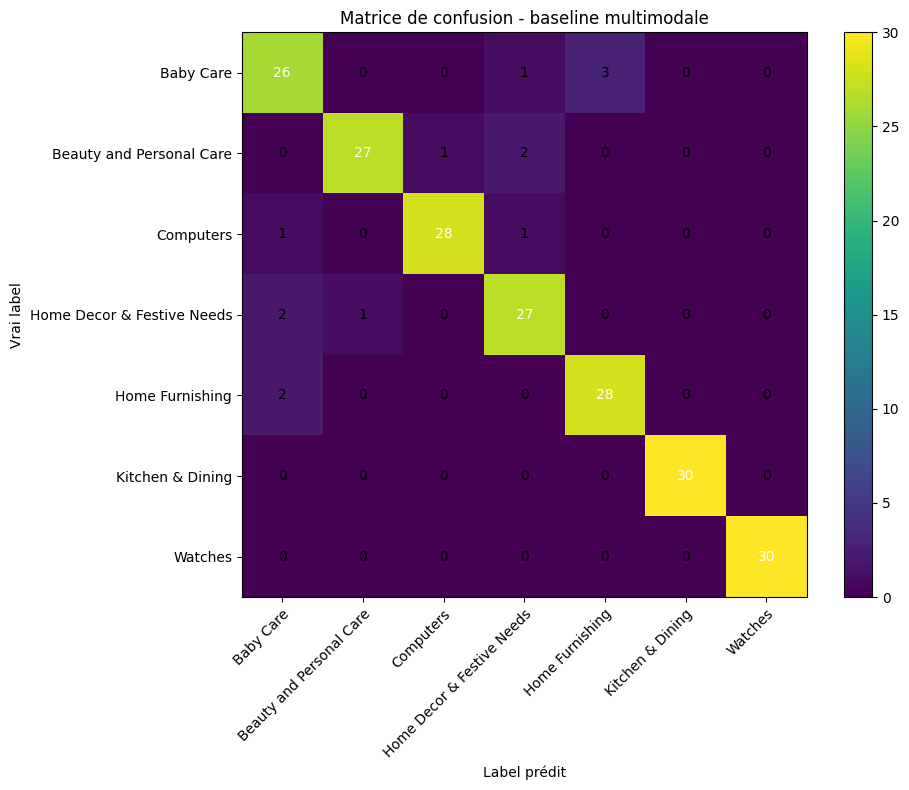

In [47]:
cm = confusion_matrix(y_test, y_pred)
labels_unique = np.unique(y_test)

fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(cm, interpolation="nearest")
ax.figure.colorbar(im, ax=ax)
ax.set(
    xticks=np.arange(len(labels_unique)),
    yticks=np.arange(len(labels_unique)),
    xticklabels=labels_unique,
    yticklabels=labels_unique,
    ylabel="Vrai label",
    xlabel="Label prédit",
    title="Matrice de confusion - baseline multimodale"
)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], "d"),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")

fig.tight_layout()
plt.show()


In [48]:
# ===============================
# 9. Interprétabilité simple (texte)
# ===============================

feature_names_text = np.array(tfidf_vectorizer.get_feature_names_out())
n_top = 15

if len(np.unique(y_train)) == 2:
    class_idx = 1
    coefs = clf.coef_[class_idx][:len(feature_names_text)]
    top_pos_idx = np.argsort(coefs)[-n_top:]
    print("Mots les plus associés à la classe index", class_idx)
    print(feature_names_text[top_pos_idx])
else:
    print("Multi-classe : interprétabilité fine à faire plus tard (SHAP, etc.).")


Multi-classe : interprétabilité fine à faire plus tard (SHAP, etc.).


## Conclusion – Faisabilité

Dans ce notebook, nous avons :

- Utilisé **product_name** + **description** comme texte.
- Extrait la **catégorie principale** depuis `product_category_tree` comme variable cible.
- Utilisé les fichiers `image` comme source de la modalité image.
- Prétraité le texte avec **TF-IDF**.
- Prétraité les images avec un **CNN pré-entraîné MobileNetV2** (couches gelées).
- Fusionné les deux modalités (concaténation de features texte + image).
- Entraîné une **Logistic Regression** comme modèle baseline.
- Obtenu des performances supérieures au hasard, ce qui valide la **faisabilité technique** d’un pipeline multimodal sur ce dataset.

Pistes d’amélioration pour la suite :

- Embeddings texte plus riches (Word2Vec, FastText, BERT-like).
- Fine-tuning partiel du CNN sur ce dataset.
- Modèles plus puissants (Gradient Boosting, réseaux fully connected).
- Réduction de dimension (PCA) avant la classification.
- Optimisation systématique des hyperparamètres.
- Data augmentation sur les images.
